In [1]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import timeit
from time import sleep
import cv2.aruco as aruco
import math
from IPython.display import display, clear_output
import math, sys, os
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))

import time

from global_utils import convert_to_np,sort_coords,vis_graph,heuristic,a_star,plot_map,swap_xy
from vision_utils import *

In [6]:
#setup camera
cap = cv2.VideoCapture(1,cv2.CAP_DSHOW)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
cap.set(cv2.CAP_PROP_EXPOSURE, -4)  #adjust this to avoid reflection from A4 paper

aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250) #import Arcuo Dictionary
parameters =  aruco.DetectorParameters_create()
ext_pixels = 40 #how much to dilate
TH_Poly=0.025 #threshold for Polyfit
camera_matrix = np.array([[1007.8578, 0., 627.9454], [0., 1010.2664, 326.2529], [0., 0., 1.]], dtype=np.float32)
distortion = np.array([1.21870288e-01, -7.16272780e-01, -7.01033059e-03, -3.83577419e-04, 9.43910859e-01], dtype=np.float32)

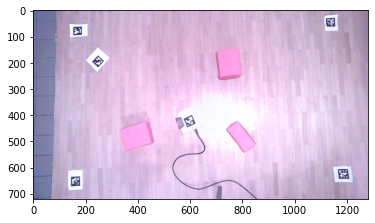

In [14]:
ret, frame = cap.read()
while(not ret):
    cap = cv2.VideoCapture(1,cv2.CAP_DSHOW)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(frame)
sleep(0.01)

In [31]:
red_lower = np.array([140, 60, 220])
red_upper = np.array([170, 100, 255])
# red_lower = np.array([140, 120, 150])
# red_upper = np.array([180, 180, 210])
# ret, frame = cap.read()
# while(not ret):
#     cap = cv2.VideoCapture(0,cv2.CAP_DSHOW)
#     cap.set(cv2.CAP_PROP_EXPOSURE, -4)
# frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
corners, ids, _ = aruco.detectMarkers(gray,aruco_dict,parameters=parameters)
corner_points = []  
#marker1=topleft   marker2=topright marker3=bottomleft marker4=bottomright
Thymio_start=[-1,-1]
Thymio_target=[-1,-1]
Thymio_dir = -1
obs_corners = []
obstacles_mask=[]
warpedimg_clean =[]
warpedimg=[]
img_out=np.ones((720,1280,3),np.uint8)*255
cam_OK = True
for i in range(1,5):  
    corner_points.append(corners[ids.tolist().index([i])][0][0].tolist())
pts1 = np.float32(corner_points)
pts2 = np.float32([[0, 0], [1280, 0], [0, 720], [1280, 720]])
transform = cv2.getPerspectiveTransform(pts1, pts2)
warpedimg = cv2.warpPerspective(frame, transform, (1280, 720))
corners, ids, _ = aruco.detectMarkers(warpedimg,aruco_dict,parameters=parameters)
Thymio_corner = corners[ids.tolist().index([0])]
rvec, tvec, _ = aruco.estimatePoseSingleMarkers(Thymio_corner, 0.05, camera_matrix, distortion)
Thymio_dir = -rotationMatrixToEulerAngles(rvec[0])[2]+180
Thymio_center = np.mean(Thymio_corner, axis=1).tolist()[0]
# Thymio_center = [int(Thymio_center[0]),int(Thymio_center[1])]
Thymio_center.reverse()
Thymio_target = np.mean(corners[ids.tolist().index([5])], axis=1).tolist()[0]
# Thymio_target = [int(Thymio_target[0]),int(Thymio_target[1])]
Thymio_target.reverse()
HSV = cv2.cvtColor(warpedimg, cv2.COLOR_RGB2HSV)
HSV_blur = cv2.GaussianBlur(HSV, (7, 7), 0)
red_mask=cv2.inRange(HSV_blur,red_lower,red_upper)
red_mask_closed = cv2.morphologyEx(red_mask, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8),iterations=2)
obstacles_mask = cv2.dilate(red_mask_closed, np.ones((int(ext_pixels*2-1),int(ext_pixels*2-1)), np.uint8), iterations=1)

contours, hierarchy = cv2.findContours(obstacles_mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
obstacles_mask[obstacles_mask==255]=1
for cnt in contours:
    if cv2.contourArea(cnt) > 1000:#drop spots
        temp = []
        epsilon = TH_Poly*cv2.arcLength(cnt,True)
        approx = cv2.approxPolyDP(cnt,epsilon,True)
        for point in approx:
            point_original = list(point[0])
            temp.append([point_original[1],point_original[0]])
        obs_corners.append(temp)



_, mask = cv2.threshold(red_mask, thresh=180, maxval=255, type=cv2.THRESH_BINARY)
img_out[mask==255] = [200,20,20]
Thymio_start = Thymio_center

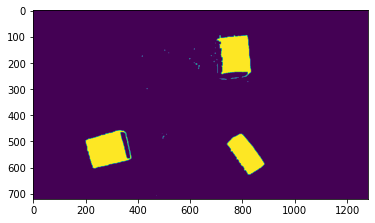

In [32]:
plt.imshow(red_mask_closed)

## Dynamic plotting

## All things below for testing

In [18]:
%%time
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
corners, ids, _ = aruco.detectMarkers(gray,aruco_dict,parameters=parameters)
corner_points = []  
#marker1=topleft   marker2=topright marker3=bottomleft marker4=bottomright
cam_OK = True
try:
    for i in range(1,5):  
        corner_points.append(corners[ids.tolist().index([i])][0][0].tolist())
    pts1 = np.float32(corner_points)
    pts2 = np.float32([[0, 0], [1280, 0], [0, 720], [1280, 720]])
    transform = cv2.getPerspectiveTransform(pts1, pts2)
    warpedimg = cv2.warpPerspective(frame, transform, (1280, 720))
except:
    cam_OK = False
#print(corner_points)

Wall time: 60.8 ms


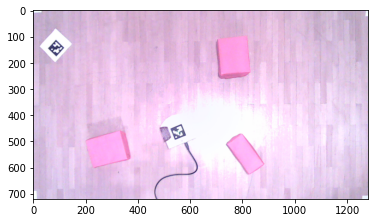

In [19]:
plt.imshow(warpedimg)

In [20]:
print(ids)

[[3]
 [4]
 [0]
 [5]
 [1]
 [2]]


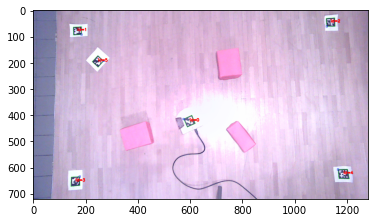

In [21]:
frame1 = frame.copy()
aruco.drawDetectedMarkers(frame1, corners,ids)
plt.imshow(frame1)
#cv2.imwrite('test4.png',cv2.cvtColor(frame1, cv2.COLOR_RGB2BGR))

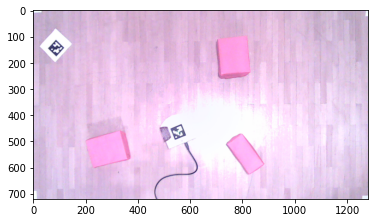

In [22]:
plt.imshow(warpedimg)
#cv2.imwrite('test5.png',cv2.cvtColor(warpedimg, cv2.COLOR_RGB2BGR))

In [23]:
%%time
try:
    corners, ids, _ = aruco.detectMarkers(warpedimg,aruco_dict,parameters=parameters)
    Thymio_corner = corners[ids.tolist().index([0])]
    rvec, tvec, _ = aruco.estimatePoseSingleMarkers(Thymio_corner, 0.05, camera_matrix, distortion)
    Thymio_dir = -rotationMatrixToEulerAngles(rvec[0])[2] + 180
    Thymio_center = np.mean(Thymio_corner, axis=1).tolist()[0]
    Thymio_center.reverse()
    Thymio_target = np.mean(corners[ids.tolist().index([5])], axis=1)
    Thymio_target.reverse()
except:
    cam_OK = False
print(f'Direction of Thymio: {Thymio_dir:0.3f} degrees, center of Thymio {Thymio_center}, center of target {Thymio_target}.')

Direction of Thymio: 202.702 degrees, center of Thymio [464.25, 554.5], center of target [[ 87.25 144.75]].
Wall time: 26.9 ms


In [24]:
HSV = cv2.cvtColor(warpedimg, cv2.COLOR_RGB2HSV)
HSV_blur = cv2.GaussianBlur(HSV, (7, 7), 0)

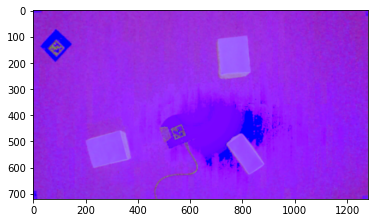

In [25]:
plt.imshow(HSV_blur)

In [26]:
def getpos(event,x,y,flags,param):
    if event==cv2.EVENT_LBUTTONDOWN:
        print(HSV_blur[y,x])
#th2=cv2.adaptiveThreshold(imagegray,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,2)
cv2.imshow("imageHSV",HSV_blur)
cv2.setMouseCallback("imageHSV",getpos)
cv2.waitKey(0)

[157  94 255]
[159  98 255]
[159  98 255]
[160  98 255]
[152  68 255]
[152  71 255]
[152  71 255]
[153  70 255]
[152  70 255]
[153  72 255]
[151  66 255]
[153  72 255]
[153  77 255]
[154  81 255]
[152  82 255]
[152  82 255]


-1

In [17]:
    red_lower = np.array([130, 50, 200])
    red_upper = np.array([185, 110, 255])

In [30]:
cam_OK

False

In [102]:
cv2.destroyAllWindows()

In [ ]:

def merge_img(map_img, thymio_img, y1, y2, x1, x2):
    '''function to overlay thymio_icon onto the graph
    jpg_img is thymio icon i'''
    if map_img.shape[2] == 3:
        map_img = add_alpha_channel(map_img)
    if thymio_img.shape[2] == 3:
        thymio_img = add_alpha_channel(thymio_img)
    yy1 = 0
    yy2 = thymio_img.shape[0]
    xx1 = 0
    xx2 = thymio_img.shape[1]
 
    if x1 < 0:
        xx1 = -x1
        x1 = 0
    if y1 < 0:
        yy1 = - y1
        y1 = 0
    if x2 > map_img.shape[1]:
        xx2 = thymio_img.shape[1] - (x2 - map_img.shape[1])
        x2 = map_img.shape[1]
    if y2 > map_img.shape[0]:
        yy2 = thymio_img.shape[0] - (y2 - map_img.shape[0])
        y2 = map_img.shape[0]
        
    alpha_thymio = thymio_img[yy1:yy2,xx1:xx2,3] / 255.0
    alpha_map = 1 - alpha_thymio
    for c in range(0,3):
        map_img[y1:y2, x1:x2, c] = ((alpha_map*map_img[y1:y2,x1:x2,c]) + (alpha_thymio*thymio_img[yy1:yy2,xx1:xx2,c]))
    return map_img

In [117]:
red_lower = np.array([140, 100, 200])
red_upper = np.array([185, 160, 255])
# red_lower = np.array([140, 120, 150])
# red_upper = np.array([185, 180, 210])

In [ ]:
red_lower_alt = np.array([0, 220, 220])
red_upper_alt = np.array([30, 255, 255])

In [186]:
thymio_icon = cv2.imread('Thymio.jpg')
thymio_icon = cv2.cvtColor(thymio_icon, cv2.COLOR_RGB2BGR)

In [12]:
def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 0.5)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

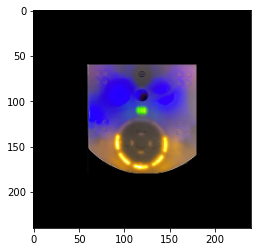

In [190]:
plt.imshow(rotate_image(thymio_icon,0))

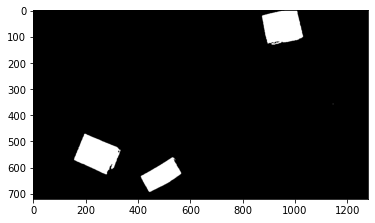

In [18]:
red_mask=cv2.inRange(HSV_blur,red_lower,red_upper)
# red_mask=cv2.inRange(HSV_blur,red_lower_alt,red_upper_alt)
plt.imshow(red_mask,cmap="gray")

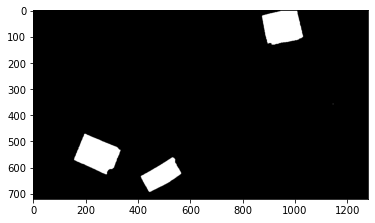

In [19]:
red_mask_closed = cv2.morphologyEx(red_mask, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8),iterations=2)
plt.imshow(red_mask_closed,cmap="gray")

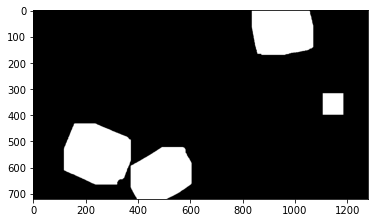

In [20]:
ext_pixels = 40 #how much to dilate
obstacles_mask = cv2.dilate(red_mask_closed, np.ones((int(ext_pixels*2-1),int(ext_pixels*2-1)), np.uint8), iterations=1)
# obstacles_mask[:1,:] = 0;
# obstacles_mask[:,:1] = 0;
# obstacles_mask[:,-1] = 0;
# obstacles_mask[-1,:] = 0;
plt.imshow(obstacles_mask,cmap="gray")

In [112]:
# warpedimg = cv2.imread('test5 - Copy.png')
# corners, ids, _ = aruco.detectMarkers(warpedimg,aruco_dict,parameters=parameters)
# Thymio_corner = corners[ids.tolist().index([0])]
# #Thymio_id = np.expand_dims(ids[ids.tolist().index([0])], axis=0)
# rvec, tvec, _ = aruco.estimatePoseSingleMarkers(Thymio_corner, 0.05, camera_matrix, distortion)
# print(-rotationMatrixToEulerAngles(rvec[0])[2])
# warpedimg2 = warpedimg.copy()
# aruco.drawAxis(warpedimg2, camera_matrix, distortion, rvec[:, :], tvec[:, :], 0.03)
# aruco.drawDetectedMarkers(warpedimg2, corners)
# plt.imshow(warpedimg2)
# warpedimg = cv2.imread('test6 - Copy.png')
# corners, ids, _ = aruco.detectMarkers(warpedimg,aruco_dict,parameters=parameters)
# Thymio_corner = corners[ids.tolist().index([0])]
# #Thymio_id = np.expand_dims(ids[ids.tolist().index([0])], axis=0)
# rvec, tvec, _ = aruco.estimatePoseSingleMarkers(Thymio_corner, 0.05, camera_matrix, distortion)
# print(-rotationMatrixToEulerAngles(rvec[0])[2])
# warpedimg2 = warpedimg.copy()
# aruco.drawAxis(warpedimg2, camera_matrix, distortion, rvec[:, :], tvec[:, :], 0.03)
# aruco.drawDetectedMarkers(warpedimg2, corners)
# plt.imshow(warpedimg2)

In [113]:
# img = cv2.imread('test_im1.png')
# img_bw = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# plt.imshow(img_bw,cmap='gray')

In [114]:
%%time
contours, hierarchy = cv2.findContours(obstacles_mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

Wall time: 1 ms


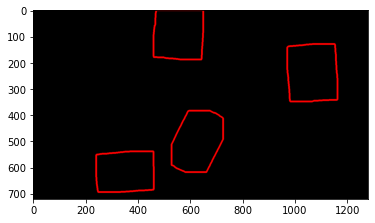

In [115]:
img_out=np.ones((obstacles_mask.shape[0],obstacles_mask.shape[1],3), np.uint8)
cv2.drawContours(img_out, contours, -1, (255, 0, 0), 5)
plt.imshow(img_out)

In [116]:
TH_Poly=0.025 #threshold for Polyfit

[[[539, 460], [550, 243], [692, 248], [684, 460]], [[383, 596], [511, 529], [590, 529], [617, 662], [492, 726], [412, 726]], [[129, 1152], [142, 971], [348, 983], [340, 1163]], [[0, 471], [179, 461], [188, 643], [0, 650]]]
Wall time: 37 ms


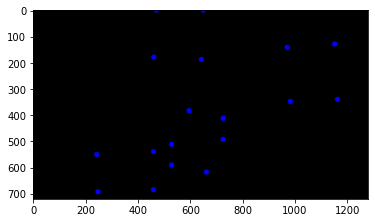

In [117]:
%%time
blank_img = np.zeros((obstacles_mask.shape[0],obstacles_mask.shape[1],3), np.uint8)
corners = []
for cnt in contours:
    if cv2.contourArea(cnt) > 1000:#drop spots
        temp = []
        epsilon = TH_Poly*cv2.arcLength(cnt,True)
        approx = cv2.approxPolyDP(cnt,epsilon,True)
        for point in approx:
            cv2.circle(blank_img,tuple(point[0]),10,[0,0,255],-1)
            point_original = list(point[0])
            temp.append([point_original[1],point_original[0]])
        corners.append(temp)
plt.imshow(blank_img)
print(corners)

In [118]:
corners

[[[539, 460], [550, 243], [692, 248], [684, 460]],
 [[383, 596], [511, 529], [590, 529], [617, 662], [492, 726], [412, 726]],
 [[129, 1152], [142, 971], [348, 983], [340, 1163]],
 [[0, 471], [179, 461], [188, 643], [0, 650]]]

In [119]:
print(f'Direction of Thymio: {Thymio_dir:0.3f} degrees, center of Thymio {Thymio_center}.')

Direction of Thymio: 92.921 degrees, center of Thymio [321.5, 86.0].


In [36]:
img_out=np.ones((HSV_blur.shape[0],HSV_blur.shape[1],3),np.uint8)*255
_, mask = cv2.threshold(red_mask, thresh=180, maxval=255, type=cv2.THRESH_BINARY)
img_out[mask==255] = [200,20,20]
thymio_icon = cv2.imread('Thymio.jpg')
thymio_icon = cv2.cvtColor(thymio_icon, cv2.COLOR_RGB2BGR)
warpedimg_clean = merge_img(img_out, rotate_image(thymio_icon,Thymio_dir), int(Thymio_center[0])-120, int(Thymio_center[0])+120, int(Thymio_center[1])-120, int(Thymio_center[1])+120)
    

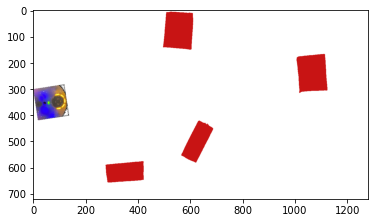

In [37]:
plt.imshow(warpedimg_clean)

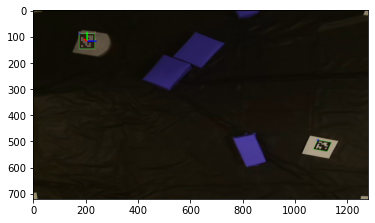

In [373]:
plt.imshow(warpedimg2)

## Function Implementation

In [3]:
#setup camera
cap = cv2.VideoCapture(0,cv2.CAP_DSHOW)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
cap.set(cv2.CAP_PROP_EXPOSURE, -4)  #adjust this to avoid reflection from A4 paper

aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250) #import Arcuo Dictionary
parameters =  aruco.DetectorParameters_create()
ext_pixels = 40 #how much to dilate
TH_Poly=0.025 #threshold for Polyfit

In [210]:
localisation_cam(cap)

(True,
 [350.75, 69.25],
 99.4089582505319,
 [637.25, 941.25],
 [array([[[937., 671.],
          [909., 634.],
          [946., 603.],
          [973., 641.]]], dtype=float32),
  array([[[ 89., 323.],
          [ 95., 371.],
          [ 49., 378.],
          [ 44., 331.]]], dtype=float32),
  [[538, 460], [551, 239], [693, 245], [685, 461]],
  [[382, 596], [512, 527], [592, 527], [619, 661], [492, 727], [412, 727]],
  [[129, 1153], [143, 968], [354, 978], [345, 1162]],
  [[0, 468], [181, 459], [189, 643], [0, 650]]])

In [208]:
def localisation_cam(cap):
    '''take camera instance as input, return if camera is ok, current Thymio pose, current obstacle map'''
    ret, frame = cap.read()
    while(not ret):
        cap = cv2.VideoCapture(0,cv2.CAP_DSHOW)
        cap.set(cv2.CAP_PROP_EXPOSURE, -4)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    corners, ids, _ = aruco.detectMarkers(gray,aruco_dict,parameters=parameters)
    corner_points = []  
    #marker1=topleft   marker2=topright marker3=bottomleft marker4=bottomright
    Thymio_center=[-1,-1]
    Thymio_target=[-1,-1]
    Thymio_dir = -1
    cam_OK = True
#     try:
    for i in range(1,5):  
        corner_points.append(corners[ids.tolist().index([i])][0][0].tolist())
    pts1 = np.float32(corner_points)
    pts2 = np.float32([[0, 0], [1280, 0], [0, 720], [1280, 720]])
    transform = cv2.getPerspectiveTransform(pts1, pts2)
    warpedimg = cv2.warpPerspective(frame, transform, (1280, 720))
    corners, ids, _ = aruco.detectMarkers(warpedimg,aruco_dict,parameters=parameters)
    Thymio_corner = corners[ids.tolist().index([0])]
    rvec, tvec, _ = aruco.estimatePoseSingleMarkers(Thymio_corner, 0.05, camera_matrix, distortion)
    Thymio_dir = -rotationMatrixToEulerAngles(rvec[0])[2]+180
    Thymio_center = np.mean(Thymio_corner, axis=1).tolist()[0]
    Thymio_center.reverse()
    Thymio_target = np.mean(corners[ids.tolist().index([5])], axis=1).tolist()[0]
    Thymio_target.reverse()
    HSV = cv2.cvtColor(warpedimg, cv2.COLOR_RGB2HSV)
    HSV_blur = cv2.GaussianBlur(HSV, (7, 7), 0)
    red_mask=cv2.inRange(HSV_blur,red_lower,red_upper)
    red_mask_closed = cv2.morphologyEx(red_mask, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8),iterations=2)
    obstacles_mask = cv2.dilate(red_mask_closed, np.ones((int(ext_pixels*2-1),int(ext_pixels*2-1)), np.uint8), iterations=1)
    obs_corners = []
    contours, hierarchy = cv2.findContours(obstacles_mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    obstacles_mask[obstacles_mask==255]=1
    for cnt in contours:
        if cv2.contourArea(cnt) > 1000:#drop spots
            temp = []
            epsilon = TH_Poly*cv2.arcLength(cnt,True)
            approx = cv2.approxPolyDP(cnt,epsilon,True)
            for point in approx:
                point_original = list(point[0])
                temp.append([point_original[1],point_original[0]])
            obs_corners.append(temp)
#     except:
#         cam_OK=False

    img_out=np.ones((HSV_blur.shape[0],HSV_blur.shape[1],3),np.uint8)*255
    _, mask = cv2.threshold(red_mask, thresh=180, maxval=255, type=cv2.THRESH_BINARY)
    img_out[mask==255] = [200,20,20]
    thymio_icon = cv2.imread('Thymio.jpg')
    thymio_icon = cv2.cvtColor(thymio_icon, cv2.COLOR_RGB2BGR)
    warpedimg_clean = merge_img(img_out, rotate_image(thymio_icon,Thymio_dir), int(Thymio_center[0])-120, int(Thymio_center[0])+120, int(Thymio_center[1])-120, int(Thymio_center[1])+120)
    return cam_OK, Thymio_center, Thymio_dir, Thymio_target, obs_corners, obstacles_mask, warpedimg, warpedimg_clean